In [207]:
%matplotlib inline
import nibabel as nib
from nibabel.processing import resample_to_output
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import re

from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import normalize
from sklearn.metrics import classification_report
from keras.wrappers.scikit_learn import KerasRegressor

seed = 42
np.random.seed(seed)  # for reproducibility

In [9]:
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cuda0,floatX=float32"
os.environ["KERAS_BACKEND"] = "theano"
import theano
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution3D, MaxPooling3D
from keras.utils import np_utils

In [41]:
# zero-pad some of the entries so they match the filenames
df = pd.read_csv('C:/Users/Leo/Documents/GradSchool/2018_IA_Hackathon/data/phenotype/phenotype_t1.csv',
                converters={'ID': lambda x: str(x).zfill(4)})
# make the ID the index in the pandas dataframe
df.set_index('ID', inplace=True)
df.head()

Gc        Gv        Gl        Gs
ID                                          
1105  1.023653  0.991524  0.462879  0.511900
1125 -0.223765 -1.001832 -1.862046 -0.327059
1130 -1.127033 -1.870645 -0.899005 -2.209004
1362 -0.063546  0.850259  0.470841  0.756666
1381  0.450993  0.810722  0.667942  0.606078

In [112]:
data = list()
i=1
labels = []
pheno = []
lesion_masks = glob('C:/Users/Leo/Documents/GradSchool/2018_IA_Hackathon/data/Hackathon_Lesion_Data/LESYMAP_trainingSet/*.nii.gz')
for les_file in lesion_masks:
    match = re.match(r'.*\\([0-9]{4}).nii.gz', les_file)
    sub_id = match.groups()[0]
    if sub_id in df.index:   
        pheno.append(df.loc[sub_id]['Gc'])
        labels.append(sub_id)
        les_img = nib.load(les_file)
        les_img_resamp = resample_to_output(les_img, voxel_sizes=(3, 3, 3))
        les_data = les_img_resamp.get_data()
        data.append(les_data)


In [117]:
data_array = np.array(data, dtype="float")
labels_array = np.array(labels, dtype="float")

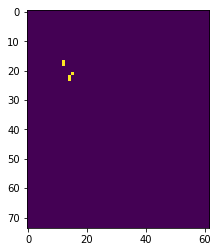

In [133]:
plt.imshow(data_array[0,20,:,:])

In [172]:
# Normalize the labels
Y = pheno / np.linalg.norm(pheno)

# Format
X = data_array.reshape(data_array.shape[0], 1, *data_array.shape[1:4])
input_shape = X[0].shape

#(trainX, testX, trainY, testY) = train_test_split(data_array, pheno_normalized, test_size=0.1, random_state=seed)

#trainX = trainX.reshape(trainX.shape[0], 1, *trainX.shape[1:4])
#testX = testX.reshape(testX.shape[0], 1, *testX.shape[1:4])

#input_shape = trainX[0].shape

In [155]:
import keras
from keras.datasets import mnist
from keras.layers import Dense, Flatten
from keras.layers import Conv3D, MaxPooling3D
from keras.models import Sequential
import matplotlib.pylab as plt
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping

In [140]:
model = Sequential()
 
model.add(Convolution3D(32, (5,5,5), activation='relu', input_shape=input_shape, data_format = 'channels_first'))
model.add(Convolution3D(32, (5,5,5), activation='relu', input_shape=input_shape, data_format = 'channels_first'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Convolution3D(64, (2,2,2), activation='relu'))
model.add(Dropout(0.25))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Convolution3D(64, (2,2,2), activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='tanh'))

In [146]:
EPOCHS = 20
BATCH = 25
model.compile(loss='mse',
              optimizer='adam',
              metrics=['mae'])
early_stopper = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              verbose=0, mode='auto')

In [147]:
H = model.fit(trainX, trainY, validation_data=(testX, testY), 
          batch_size=BATCH, nb_epoch=10, verbose=1, callbacks=[early_stopper])

C:\Users\Leo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 72 samples, validate on 9 samples
Epoch 1/10
72/72 [==============================] - 21s 296ms/step - loss: 0.0134 - mean_absolute_error: 0.0896 - val_loss: 0.0106 - val_mean_absolute_error: 0.0927
Epoch 2/10
72/72 [==============================] - 4s 59ms/step - loss: 0.0089 - mean_absolute_error: 0.0757 - val_loss: 0.0090 - val_mean_absolute_error: 0.0813
Epoch 3/10
72/72 [==============================] - 4s 59ms/step - loss: 0.0070 - mean_absolute_error: 0.0674 - val_loss: 0.0100 - val_mean_absolute_error: 0.0871
Epoch 4/10
72/72 [==============================] - 4s 60ms/step - loss: 0.0059 - mean_absolute_error: 0.0635 - val_loss: 0.0094 - val_mean_absolute_error: 0.0807
Epoch 5/10
72/72 [==============================] - 4s 59ms/step - loss: 0.0053 - mean_absolute_error: 0.0582 - val_loss: 0.0109 - val_mean_absolute_error: 0.1004
Epoch 6/10
72/72 [==============================] - 4s 59ms/step - loss: 0.0054 - mean_absolute_error: 0.0599 - val_loss: 0.0082 - val_mean_

In [182]:
X[0:20].shape


(20, 1, 62, 74, 62)

In [185]:
kfold.split(range(0,20), )

TypeError: Singleton array array(1) cannot be considered a valid collection.

In [187]:
kfold

StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

In [197]:
# define the model
def keras_model():
    model = Sequential()
    model.add(Convolution3D(32, (5,5,5), activation='relu', input_shape=input_shape, data_format = 'channels_first'))
    model.add(Convolution3D(32, (5,5,5), activation='relu', input_shape=input_shape, data_format = 'channels_first'))
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    model.add(Convolution3D(64, (2,2,2), activation='relu'))
    model.add(Dropout(0.25))
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    model.add(Convolution3D(64, (2,2,2), activation='relu'))
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))# Compile model
    model.compile(loss='mse',
              optimizer='adam',
              metrics=['mae'])
    return model

In [212]:
# training param
EPOCHS = 5
BATCH = 5
#early_stopper = EarlyStopping(monitor='val_loss',
                              #min_delta=0,
                              #patience=5,
                              #verbose=0, mode='auto')

# cross-validation
np.random.seed(seed)
estimator = KerasRegressor(build_fn=keras_model, epochs=EPOCHS, batch_size=BATCH, verbose=0)
kfold = KFold(n_splits=2, shuffle=True, random_state=seed)
results = cross_val_score(estimator, X, Y, cv=kfold)

In [211]:
results

{'fit_time': array([20.66748071, 21.48667574]),
 'score_time': array([1.48883057, 1.50585389]),
 'test_score': array([-0.01310817, -0.0117336 ]),
 'train_score': array([-0.00600754, -0.01138218])}

In [205]:
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Results: -0.01 (0.00) MSE


In [ ]:
# plot the training loss and accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["mean_absolute_error"], label="train_mae")
plt.plot(N, H.history["val_mean_absolute_error"], label="val_mae")
plt.title("Training Loss and Accuracy (Simple NN)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
# plt.savefig(args["plot"])

In [206]:
results.argpartition

SyntaxError: invalid syntax (<ipython-input-206-91f4f5fd1e4b>, line 1)